In [2]:
import pandas as pd
import lizard

# File paths (Update as needed)
input_csv = "Output.csv"  # CSV containing Java code
metrics_csv = "MI_1200.csv"  # CSV to store computed metrics

# Load input CSV
input_df = pd.read_csv(input_csv)

# Function to compute Cyclomatic Complexity (CC)
def compute_cc(java_code):
    # Handle NaN values: If the input is NaN, treat it as an empty string
    if isinstance(java_code, float) and pd.isna(java_code):
        java_code = ""
    
    # Analyze the Java code using Lizard
    analysis = lizard.analyze_file.analyze_source_code("Example.java", java_code)
    
    # Sum the cyclomatic complexity of all functions in the code
    return sum(func.cyclomatic_complexity for func in analysis.function_list)

# Compute CC for each Java code snippet
input_df["CC"] = input_df["Generated Java Code"].apply(compute_cc)

# Load metrics CSV (if exists), otherwise create new
try:
    metrics_df = pd.read_csv(metrics_csv)
except FileNotFoundError:
    metrics_df = pd.DataFrame(columns=["Example", "Halstead_Volume"])

# Merge CC values with existing metrics
metrics_df = metrics_df.merge(input_df[["Example", "CC"]], on="Example", how="left")

# Save the updated metrics CSV
metrics_df.to_csv(metrics_csv, index=False)

print("Cyclomatic Complexity values added successfully!")

Cyclomatic Complexity values added successfully!


LOC

In [3]:
# Function to calculate Lines of Code (LOC)
def calculate_loc(java_code):
    # Handle NaN values: If the input is NaN, treat it as an empty string
    if isinstance(java_code, float) and pd.isna(java_code):
        java_code = ""
    
    # Split the code into lines and count non-empty lines
    lines = java_code.splitlines()
    
    # Filter out empty lines and comment lines
    non_empty_lines = [
        line for line in lines 
        if line.strip() and not line.strip().startswith(("//", "/*", "*", "*/"))
    ]
    
    # Return the count of non-empty lines
    return len(non_empty_lines)

# Calculate LOC for each Java code snippet
input_df["LOC"] = input_df["Generated Java Code"].apply(calculate_loc)

# Load metrics CSV (if exists), otherwise create new
try:
    metrics_df = pd.read_csv(metrics_csv)
    metrics_df.columns = metrics_df.columns.str.strip()  # Strip spaces from column names
except FileNotFoundError:
    metrics_df = pd.DataFrame(columns=["Example", "Halstead_Volume", "CC"])

# Merge LOC values with existing metrics
metrics_df = metrics_df.merge(input_df[["Example", "LOC"]], on="Example", how="left")

# Save the updated metrics CSV
metrics_df.to_csv(metrics_csv, index=False)

print("Lines of Code (LOC) values added successfully!")

Lines of Code (LOC) values added successfully!


MI


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
input_csv = "MI_1200.csv"  # Input CSV file
output_folder = "reports"  # Folder to save the output CSV
output_csv = os.path.join(output_folder, "Final_MI_1200.csv")  # Output CSV file path

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load the CSV file
df = pd.read_csv(input_csv)

# Ensure column names are stripped of leading/trailing spaces
df.columns = df.columns.str.strip()

# Function to calculate Maintainability Index (MI)
def calculate_mi(row):
    # Check if all columns are zero or invalid
    if row["Halstead_Volume"] == 0 and row["CC"] == 0 and row["LOC"] == 0:
        return 0, "NO Generated Code"
    
    # Calculate MI only if the values are valid
    try:
        mi = (
            171
            - 5.2 * np.log(row["Halstead_Volume"])
            - 0.23 * row["CC"]
            - 16.2 * np.log(row["LOC"])
        )
    except (ValueError, ZeroDivisionError):
        # Handle cases where log(0) or other invalid operations occur
        return 0, "NO Generated Code"
    
    # Interpret the MI value
    if mi > 8.5:
        interpretation = "Highly Maintainable"
    elif mi > 6.5:
        interpretation = "Moderately Maintainable"
    else:
        interpretation = "Difficult to Maintain"
    
    return mi, interpretation

# Apply the function to calculate MI and MI_Interpretation
df[["MI", "MI_Interpretation"]] = df.apply(calculate_mi, axis=1, result_type="expand")

# Save the updated DataFrame to the specified folder
df.to_csv(output_csv, index=False)

print(f"Maintainability Index (MI) calculated and saved to {output_csv}.")



Maintainability Index (MI) calculated and saved to reports\Final_MI_1200.csv.


Average of ALL

In [ ]:
# Calculate the average MI (excluding rows with MI = 0 or "NO Generated Code")
valid_mi_df = df[(df["MI"] != 0) & (df["MI_Interpretation"] != "NO Generated Code")]
average_mi = valid_mi_df["MI"].mean()

# Round the average MI to 2 decimal places
average_mi_rounded = round(average_mi, 4)

# Interpret the average MI
if average_mi_rounded > 8.5:
    average_interpretation = "Highly Maintainable"
elif average_mi_rounded > 6.5:
    average_interpretation = "Moderately Maintainable"
else:
    average_interpretation = "Difficult to Maintain"

# Print the results
print(f"MI Rating to LLM = {average_mi_rounded}")
print(f"MI Interpretation for Average MI = {average_interpretation}")

MI Rating to LLM = 63.1182
MI Interpretation for Average MI = Difficult to Maintain


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths and corresponding tags
file_paths = {
    "Gemini-pro": "reports/Final_MI_200.csv",
    "Gemini 2.0-flash": "reports/Final_MI_1200.csv"
}

# Initialize a dictionary to store results
results = {
    "Model": [],
    "Average MI": [],
    "Interpretation": []
}

# Process each file
for model, file_path in file_paths.items():
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter out rows with MI = 0 or "NO Generated Code"
    valid_mi_df = df[(df["MI"] != 0) & (df["MI_Interpretation"] != "NO Generated Code")]
    
    # Calculate the average MI
    average_mi = valid_mi_df["MI"].mean()
    average_mi_rounded = round(average_mi, 4)
    
    # Interpret the average MI
    if average_mi_rounded > 8.5:
        average_interpretation = "Highly Maintainable"
    elif average_mi_rounded > 6.5:
        average_interpretation = "Moderately Maintainable"
    else:
        average_interpretation = "Difficult to Maintain"
    
    # Store the results
    results["Model"].append(model)
    results["Average MI"].append(average_mi_rounded)
    results["Interpretation"].append(average_interpretation)
    
    # Print the results
    print(f"Results for {model}:")
    print(f"MI Rating = {average_mi_rounded}")
    print(f"MI Interpretation = {average_interpretation}")
    print("-" * 40)



Results for Gemini-pro:
MI Rating = 66.6664
MI Interpretation = Moderately Maintainable
----------------------------------------
Results for Gemini 2.0-flash:
MI Rating = 63.1182
MI Interpretation = Difficult to Maintain
----------------------------------------


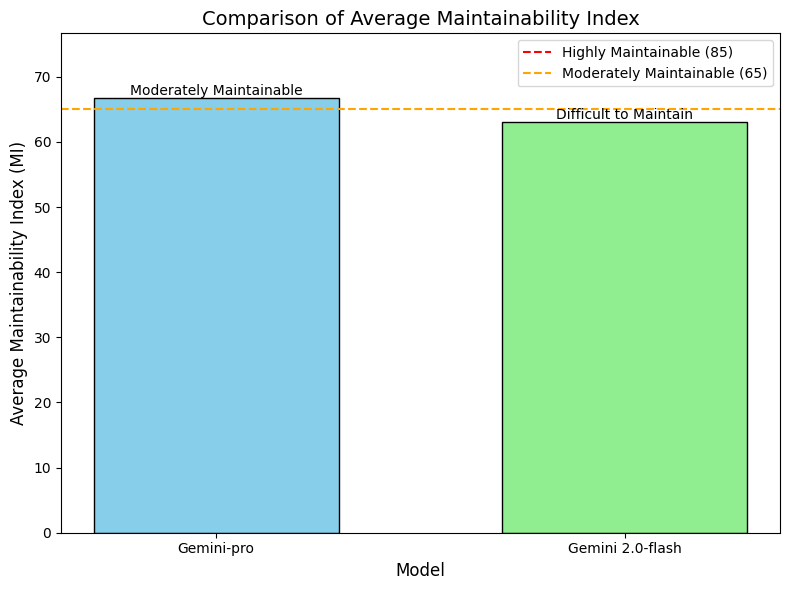

In [15]:
# Create a DataFrame for plotting
results_df = pd.DataFrame(results)

# Plot the bar chart with touching bars
plt.figure(figsize=(8, 6))
bars = plt.bar(results_df["Model"], results_df["Average MI"], color=['skyblue', 'lightgreen'], width=0.6, edgecolor='black')  # Wider bars with no gap

# Add horizontal lines for thresholds
plt.axhline(y=85, color='red', linestyle='--', label="Highly Maintainable (85)")
plt.axhline(y=65, color='orange', linestyle='--', label="Moderately Maintainable (65)")

# Add labels and title
plt.xlabel("Model", fontsize=12)
plt.ylabel("Average Maintainability Index (MI)", fontsize=12)
plt.title("Comparison of Average Maintainability Index", fontsize=14)

# Add interpretation text on the bars
for bar, interpretation in zip(bars, results_df["Interpretation"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, interpretation,
             ha='center', va='bottom', fontsize=10, color='black')

# Adjust y-axis limits
plt.ylim(0, max(results_df["Average MI"]) + 10)  # Add some padding to the y-axis

# Add legend for the horizontal lines
plt.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()